### Document binarization task

The binarization task is to classify all image pixels into two classes -
"object" and "background". The input to the binarization algorithm is a
full-color (multichannel) or isochromatic (single-channel, "in
grayscale") image, and the output should be a binary image. Its pixels
contain 1 if the corresponding pixel in the original image refers to the
object, and 0 if it refers to the background.

This formulation of the problem requires determining how the object
differs from the background. Often the difference lies in the brightness
of the pixels: for example, the brightness of black letters is less than
the brightness of white paper on which they are printed. Algorithms that
set the task of finding a common threshold T for the entire image that
separates the brightness of the object and background pixels are called
global binarization algorithms. One of them, the Otsu algorithm \[1\],
has found wide practical application.

Provided that the brightness distributions of the background and the
object are normal, have the same variance and the number of pixels of
the object and the background are equal, the Otsu criterion is optimal
in the sense of maximum likelihood. In \[2\], a modification of the Otsu
criterion is proposed for the case when the weights of the classes of
the object and the background are not a priori equal.

Another class is local binarization algorithms, which construct its own
threshold $T(x,y)$ for each image point. The most common
approach to solving this problem was proposed by W. Niblack \[3\].

In accordance with this approach, the threshold function is sought as:

$T(x,y) = \mu( x,y) + ασ(x,y)$,

where $\mu$ is the average over a certain window (area) in the image
around the point $(x,y)$, $\sigma$ is the standard
deviation of pixel brightness in the window, and $\alpha$ is an
algorithm parameter.

V. Postnikov in the early 2000s proposed (but not published) a
multiscale modification of the Niblack algorithm: when the scatter
$\sigma$ is less than the threshold $\sigma_{0}$, the decision is not
made, but instead the window size for this point is doubled and the
algorithm is applied to it. The procedure is repeated until a decision
can be taken. If this cannot be done even for a window size that
coincides with the image size, then the task of binarization of this
image with such settings is trivial: there are no sufficiently
noticeable structures in the image, so there is no point in classifying
individual pixels either.

<span id="_bookmark3" class="anchor"></span>

\[1\] Otsu N. A threshold selection method from gray-level histograms// [IEEE transactions on systems, man, and cybernetics](http://dx.doi.org/10.1109/TSMC.1979.4310076). – 1979. –Vol. 9, no. 1. – P. 62–66

\[2\] Kurita T., Otsu N., Abdelmalek N. Maximum likelihood thresholding
based on population mixture models // [Pattern recognition](http://dx.doi.org/10.1016/0031-3203(92)90024-D). – 1992. –Vol. 25, no. 10. – P. 1231–1240.

\[3\] Niblack W. An Introduction to Digital Image Processing. – Prentice Hall, 1986. – P. 115–116.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg

In [2]:
img = cv2.imread("test/000000.png", cv2.IMREAD_GRAYSCALE)

In [3]:
def show_bin_img(img, trh, title):
    binary_alg_img = img > trh
    plt.figure(figsize = (8, 8))
    plt.imshow(binary_alg_img, cmap='gray')
    plt.title(title)
    plt.axis('off')

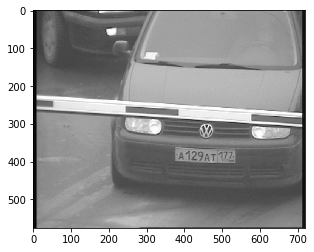

In [4]:
plt.imshow(img, cmap='gray');

### Otsu

In [5]:
def otsu_treshold(image):
    # диапазон интенсивности пикселя = [0,255], следовательно карманов +1
    bins_num = 256
    
    # Вытащим гистограмму изображения
    hist, bin_edges = np.histogram(image, bins=bins_num)

    # Посчитаем центры карманов
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

    # Перебираем все пороги и получаем вероятности
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]

    # Получим средние класса 0 
    mean1 = np.cumsum(hist * bin_mids) / weight1
    # Получим средние класса 1
    mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]
    
    
    # Обрежем концы для выравнивания переменных класса 0 и класса 1
    # Последнее значение "weight1" и "mean1" должно сочетаться 
    # с нулевыми значениями в "weight2" и "mean2", которых нет.
    # Посчитаем дисперсию между классами
    between_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

    # Найдем индекс макс значения дисперсии
    index_of_max_val = np.argmax(between_class_variance)
    
    # Через этот индекс найдем центр интревала, это и будет порог
    threshold = bin_mids[:-1][index_of_max_val]
    
    return threshold

127.005859375


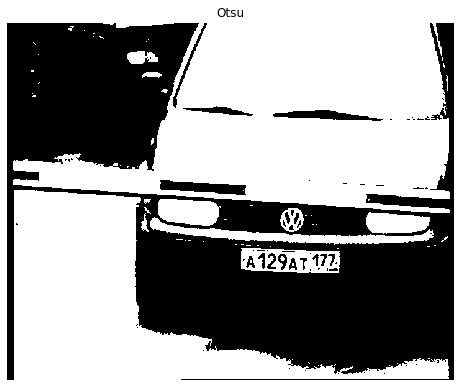

In [6]:
otsu_trh = otsu_treshold(img)
print(otsu_trh)
show_bin_img(img, otsu_trh, "Otsu")

### Otsu modified

In [7]:
def otsu_threshold_modified(img):
        histogram, bins = np.histogram(img, np.arange(255))
        p_i = histogram / np.sum(histogram)
        thresholds = np.arange(1, 255) 
        loglhs = []
        
        for thr in thresholds:
            weight_0 = p_i[:thr]
            weight_1 = p_i[thr:]
            weight_tot_0 = np.sum(weight_0)
            weight_tot_1 = np.sum(weight_1)

            mean_0 = np.sum(weight_0 * thresholds[:thr] / weight_tot_0) if weight_tot_0 > 0 else 0
            log_weight_0 = weight_tot_0 * np.log(weight_tot_0) if weight_tot_0 > 0 else 0
            var_0 = np.sum(((thresholds[:thr] - mean_0)**2)* weight_0/ weight_tot_0) if weight_tot_0 > 0 else 0

            mean_1 = np.sum(weight_1 * thresholds[thr:] / weight_tot_1) if weight_tot_1 > 0 else 0
            log_weight_1 = weight_tot_1 * np.log(weight_tot_1) if weight_tot_1 > 0 else 0
            var_1 = np.sum(((thresholds[thr:] - mean_1)**2)* weight_1/ weight_tot_1) if weight_tot_1 > 0 else 0

            var_w =  weight_tot_0 * var_0 + weight_tot_1 * var_1
            log_var_w = np.log(var_w)/2
            log_sum = log_weight_0 + log_weight_1
            loglh = log_sum - log_var_w
            loglhs.append(loglh)
        loglhs = np.array(loglhs)
        loglhs_diff = np.diff(loglhs) # разница сокр степ свободы на 1
        #найдем индекс точек макс при изменении знака производной с + на - :
        thr_opt =[]
        for x in range(loglhs_diff.size - 1): # сокр на 1 из-за смены знака
            if np.sign(loglhs_diff[x]) > np.sign(loglhs_diff[x+1]):
                thr_opt.append(x+2) # прибавляем +2 вычтенные из np.diff и np.size
        opt_index = np.argmax(loglhs[thr_opt])
        threshold = thr_opt[opt_index]
        return threshold

125


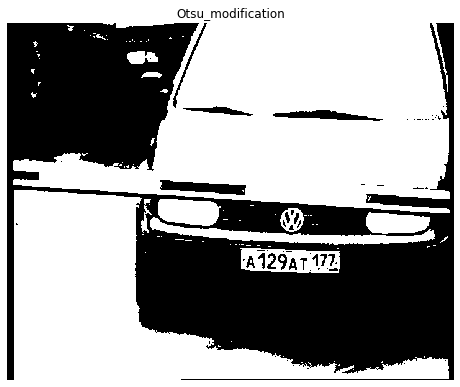

In [32]:
otsu_trh2 = otsu_threshold_modified(img)
print(otsu_trh2)
show_bin_img(img, otsu_trh2, "Otsu_modification")

### Niblack

In [15]:
#[1] http://www.isa.ru/proceedings/images/documents/2014-64-3/t-14-3_25-34.pdf  
#[2] https://link.springer.com/article/10.1134%2FS1054661816030020  
#[3] https://arxiv.org/ftp/arxiv/papers/1201/1201.5227.pdf
def niblack_threshold(img, w_size=15, k=-0.2):

    # Зададим строки и столбцы
    rows, cols = img.shape
    i_rows, i_cols = rows + 1, cols + 1
    
    # Инициализируем матрицы итегральных сумм
    integral_sum = np.zeros((i_rows, i_cols), np.float)
    sqrt_integral_sum = np.zeros((i_rows, i_cols), np.float)
    
    # накопленные суммы по x и y, оставим первые строки и столбцы нулями для спокойствия
    # исходя из [1] и [2] можно использовать интегральные суммы второго порядка для ускорения вычислений локального стд. откл-я
    integral_sum[1:, 1:] = np.cumsum(np.cumsum(img.astype(np.float), axis=0), axis=1)
    sqr_img = np.square(img.astype(np.float))
    sqrt_integral_sum[1:, 1:] = np.cumsum(np.cumsum(sqr_img, axis=0), axis=1)

    # Создадим координатную сетку с размерами изображения
    x, y = np.meshgrid(np.arange(1, i_cols), np.arange(1, i_rows))

    # w_size должно быть нечетным по условию, 
    # возьмем целое четное от деления на 2 (потому две стороны по каждой координате) для суммирования с локальным окном
    hw_size = w_size // 2 
    
    # все что меньше 1-го приравниваем 1-ке, а все что выше - приравниваем к cols и rows соответственно
    # обрезаем окна на краях
    x1 = (x - hw_size).clip(1, cols)
    x2 = (x + hw_size).clip(1, cols)
    y1 = (y - hw_size).clip(1, rows)
    y2 = (y + hw_size).clip(1, rows)

    # Зададим размер локального окна
    lw_size = (y2 - y1 + 1) * (x2 - x1 + 1)

    # Посчитаем интегральные суммы изображения
    # y1, y2  - это кум-суммы по строкам, а x1, x2  - это кум-суммы по стоблцам
    sums = (integral_sum[y2, x2] - integral_sum[y2, x1 - 1] -
            integral_sum[y1 - 1, x2] + integral_sum[y1 - 1, x1 - 1])
    sqr_sums = (sqrt_integral_sum[y2, x2] - sqrt_integral_sum[y2, x1 - 1] -
                sqrt_integral_sum[y1 - 1, x2] + sqrt_integral_sum[y1 - 1, x1 - 1])

    # Вычислим локальное среднее
    means = sums / lw_size

    # Вычислим локальное стд. отклонение как корень из разности средней квадрата и квадрата средней (интегральной суммы)
    stds = np.sqrt(sqr_sums / lw_size - np.square(means))

    # Получим матрицу порогов
    thresholds = means + k * stds

    return thresholds

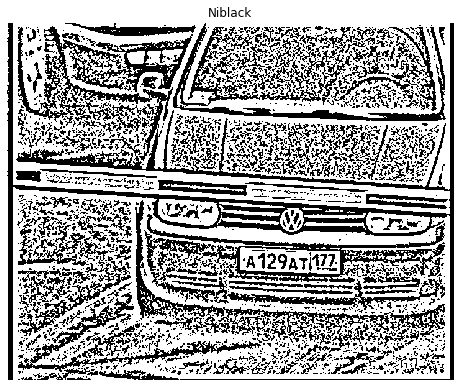

In [16]:
niblack_trh = niblack_threshold(img, w_size=15, k=-0.2)
show_bin_img(img, niblack_trh, "Niblack")

### Postnikov

In [330]:
def postnikov_threshold(img, w_size=15, k=-0.2, std_thresh=10):

    # Зададим строки и столбцы
    rows, cols = img.shape
    i_rows, i_cols = rows + 1, cols + 1
    
    # Инициализируем матрицы итегральных сумм
    integral_sum = np.zeros((i_rows, i_cols), np.float)
    sqr_integral_sum = np.zeros((i_rows, i_cols), np.float)
    
    # накопленные суммы по x и y, оставим первые строки и столбцы нулями для спокойствия
    # исходя из [1] и [2] можно использовать интегральные суммы второго порядка для ускорения вычислений локального стд. откл-я
    integral_sum[1:, 1:] = np.cumsum(np.cumsum(img.astype(np.float), axis=0), axis=1)
    sqr_img = np.square(img.astype(np.float))
    sqr_integral_sum[1:, 1:] = np.cumsum(np.cumsum(sqr_img, axis=0), axis=1)

    # Создадим координатную сетку с размерами изображения
    x, y = np.meshgrid(np.arange(1, i_cols), np.arange(1, i_rows))

    # w_size должно быть нечетным по условию, 
    # возьмем целое четное от деления на 2 (потому две стороны по каждой координате) для суммирования с локальным окном
    min_sh = np.min(img.shape)
    
    # создадим весь range окон до стороны изображения:
    wds = [w_size * (2 ** n) for n in range(0, int(math.log2(min_sh/w_size))+1)]
    wds.append(min_sh) # добавим мин сторону как крайнюю границу
    thresholds = []
    std_diffs = []
    for win_size in wds:
        hw_size = win_size // 2 
    
        # все что меньше 1-го приравниваем 1-ке, а все что выше - приравниваем к cols и rows соответственно
        # обрезаем окна на краях
        x1 = (x - hw_size).clip(1, cols)
        x2 = (x + hw_size).clip(1, cols)
        y1 = (y - hw_size).clip(1, rows)
        y2 = (y + hw_size).clip(1, rows)

        # Зададим размер локального окна
        lw_size = (y2 - y1 + 1) * (x2 - x1 + 1)

        # Посчитаем интегральные суммы изображения
        # y1, y2  - это кум-суммы по строкам, а x1, x2  - это кум-суммы по стоблцам
        sums = (integral_sum[y2, x2] - integral_sum[y2, x1 - 1] -
                integral_sum[y1 - 1, x2] + integral_sum[y1 - 1, x1 - 1])
        sqr_sums = (sqr_integral_sum[y2, x2] - sqr_integral_sum[y2, x1 - 1] -
                    sqr_integral_sum[y1 - 1, x2] + sqr_integral_sum[y1 - 1, x1 - 1])

        # Вычислим локальное среднее
        means = sums / lw_size

        # Вычислим локальное стд. отклонение как корень из разности средней квадрата и квадрата средней (интегральной суммы)
        stds = np.sqrt(sqr_sums / lw_size - np.square(means))
        
        threshold = means + k * stds
        std_diff = stds-std_thresh # найдем разницу стд. отклон-й
        
        thresholds.append(threshold)
        std_diffs.append(std_diff)

    thresholds = np.stack(thresholds)
    std_diffs = np.stack(std_diffs)
    
    # если стд. отклон меньше или равно порогу стд. отклон-я, 
    # то создадим бин маску, умножим ее на большое число и прибавим ко всем порогам, далее найдем мин по строкам
    # таким образом из тензора получим матрицу из первых минимальных порогов, в которых стд. откдон-я больше заданных:
    bin_mask = np.less_equal(std_diffs,0).astype(int)
    if np.sum(bin_mask[-1])>0:
        return print('достаточно заметных структур на изображении нет')
    else:
        return np.min(bin_mask*1000 + thresholds,0)

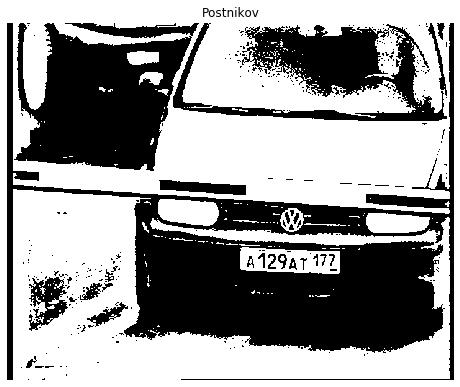

In [331]:
post_trh = postnikov_threshold(img, w_size=15, k=0.2, std_thresh=20)
show_bin_img(img, post_trh, "Postnikov")

In [297]:
def binarize(name, w_size, k, std_thresh):
        print(name)
        img = cv2.imread("test/"+name, cv2.IMREAD_GRAYSCALE)
        otsu_trh = otsu_treshold(img)
        otsu_trh2 = otsu_threshold_modified(img)
        niblack_trh = niblack_threshold(img, w_size=w_size, k=k)
        post_trh = postnikov_threshold(img, w_size=w_size, k=k, std_thresh=std_thresh)
        binary_alg_img1 = img > otsu_trh
        binary_alg_img2 = img > otsu_trh2
        binary_alg_img3 = img > niblack_trh
        binary_alg_img4 = img > post_trh

        fig, ax = plt.subplots(1, 4, figsize=(20,15))
        ax[0].imshow(binary_alg_img1, cmap='gray')
        ax[0].set_title("Otsu")
        ax[0].axis('off')
        ax[1].imshow(binary_alg_img2, cmap='gray')
        ax[1].set_title("Otsu modified")
        ax[1].axis('off')
        ax[2].imshow(binary_alg_img3, cmap='gray')
        ax[2].set_title("Niblack")
        ax[2].axis('off')
        ax[3].imshow(binary_alg_img4, cmap='gray')
        ax[3].set_title("Postnikov")
        ax[3].axis('off')

16.jpg


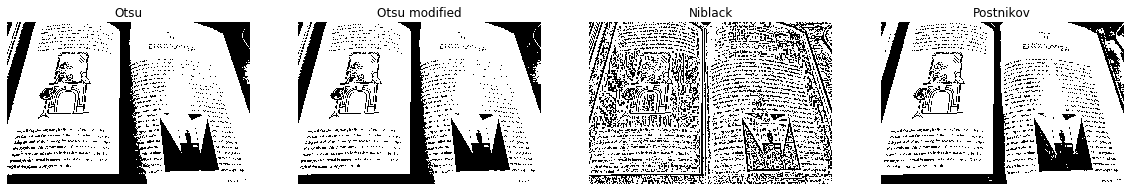

In [298]:
binarize('16.jpg', w_size=15, k=-0.2, std_thresh=30) # здесь по Ниблэку особого смысла нет применять

15.jpg


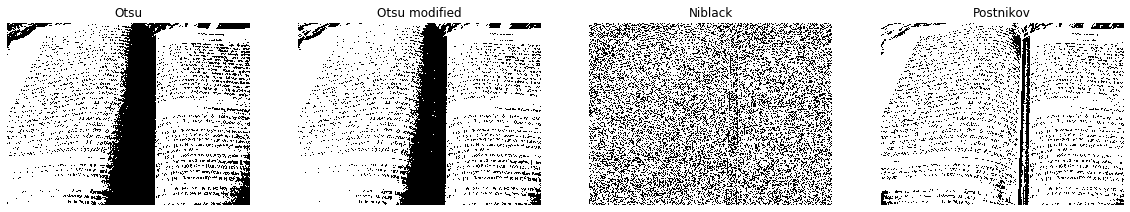

In [336]:
binarize('15.jpg', w_size=15, k=-0.2, std_thresh=10) # здесь по Оцу - неравномерное освещение, по Ниблэку тоже смысла нет применять

22.jpg


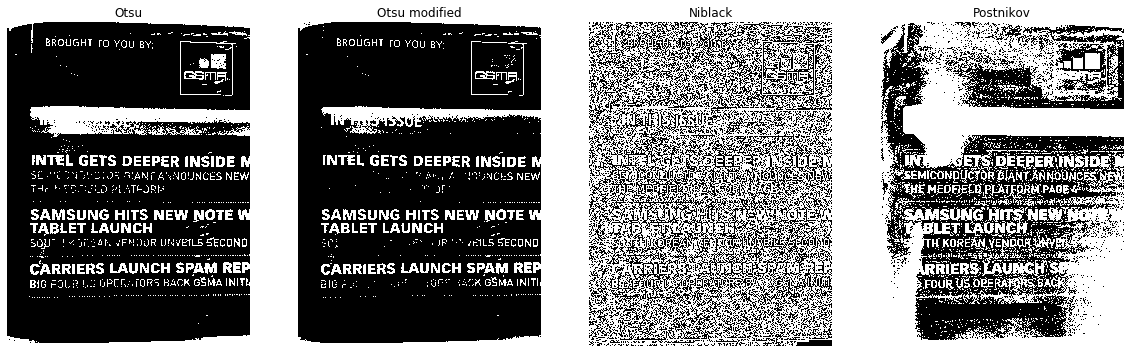

In [333]:
binarize('22.jpg', w_size=15, k=-0.3, std_thresh=20) # здесь по последним двум нет особого смысла нет применять

13.jpg


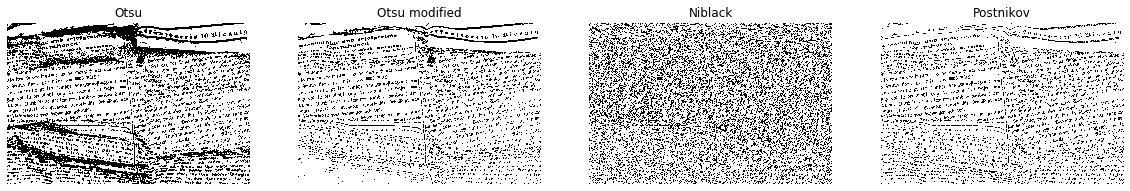

In [337]:
binarize('13.jpg', w_size=15, k=-0.4, std_thresh=10) # здесь по последним Ниблэку смысла нет применять - слишком много слабовыраженных структур

0.jpg


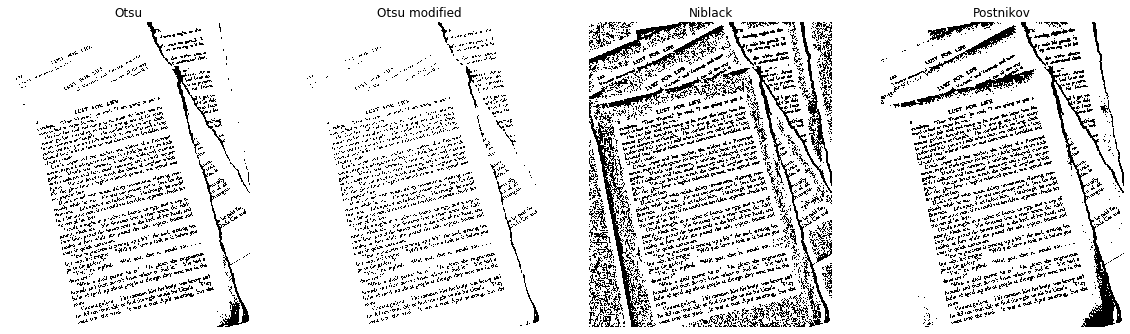

In [338]:
binarize('0.jpg', w_size=29, k=-0.2, std_thresh=20) # по Ниблэку плохо справляется - на фоне появляется грязь

1.jpg


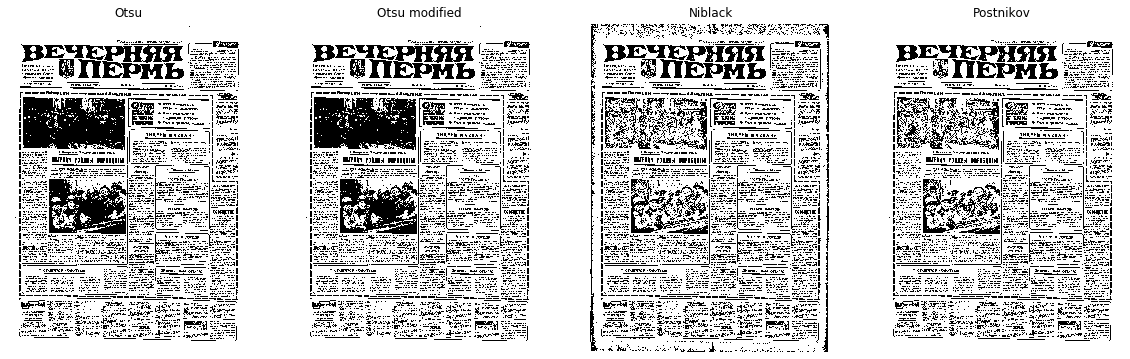

In [339]:
binarize('1.jpg', w_size=37, k=-0.5, std_thresh=20) # 1,2 хорошо, 3 - текст можно разглядеть а изобр-я на газете нет

2.jpg


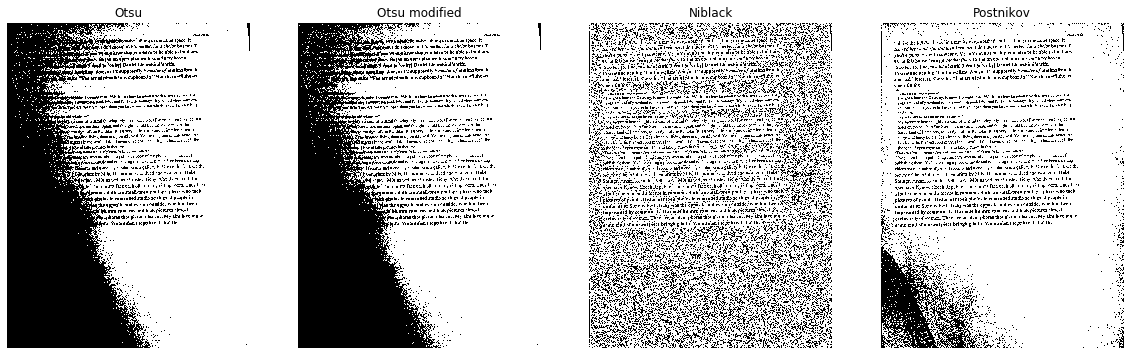

In [342]:
binarize('2.jpg', w_size=25, k=-0.5, std_thresh=10) # только по Постникову, у первых двух - плохое освещение

31.jpg


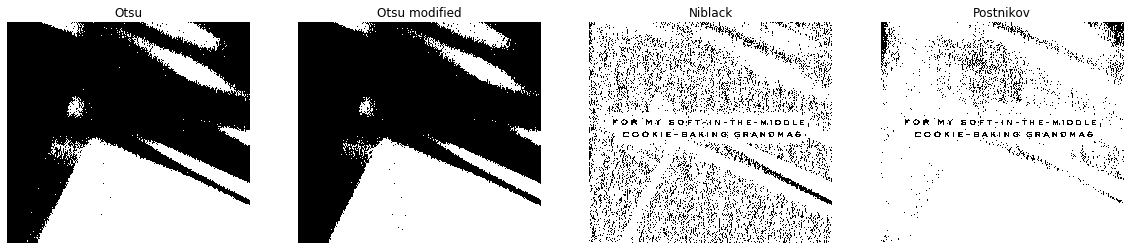

In [344]:
binarize('31.jpg', w_size=45, k=-0.8, std_thresh=20) # по Оцу смысла нет особо, - неравномерное освещение, много теней.

000000.png


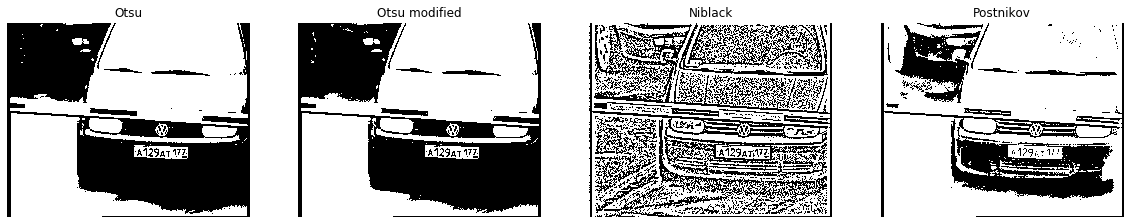

In [345]:
binarize('000000.png', w_size=15, k=-0.15, std_thresh=10)